In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 22})

In [3]:
folder_path = './color_gray'

In [4]:
files = [os.path.join(folder_path,each) for each in os.listdir(folder_path) if each.startswith('jatos')]

In [5]:
files

['./color_gray/jatos_results_20210523222838.txt',
 './color_gray/jatos_results_20210523222817.txt',
 './color_gray/jatos_results_20210523222843.txt',
 './color_gray/jatos_results_20210523222827.txt',
 './color_gray/jatos_results_20210523222832.txt',
 './color_gray/jatos_results_20210523222823.txt']

## Data Statistics

In [6]:
demographics = []
for file_path in files:
    with open(file_path,'rb') as f:
        df = pd.read_json(f)
    disclaimer = {'participate':df.iloc[0]['do-you-agree-to-participate-and-are-you-above-18-years-old.-undefined'],
                    'gender':df.iloc[0]['what-describes-you-best-(male-female-others-prefer-not-to-say)'],
                    'age':df.iloc[0]['please-enter-your-age-in-years.-(digits-only)'],
                    'need_glasses':df.iloc[0]['do-you-need-glassescontact-lenses-to-read'],
                    'wearing_them':df.iloc[0]['are-you-wearing-them-(put-']}
    demographics.append(disclaimer)

In [7]:
pd.DataFrame.from_dict(demographics)

,participate,gender,age,need_glasses,wearing_them
0,1.0,Female,24.0,Yes,Yes
1,1.0,male,58.0,yes,yes
2,1.0,Male,25.0,yes,yes
3,1.0,Male,52.0,No,NA
4,1.0,Male,26.0,No,NA
5,1.0,Female,31.0,No,NA


## Data Processing

In [8]:
types = ['Trial_200','Trial_400','Trial_600','Trial_800','Trial_1000']

def calculate_percent_correct(type_):
    count = 0
    for val in type_:
        if val['correct'] == 1:
            count += 1
    return 100*(count/len(type_))

def get_duration(type_,types):
    lim = int(type_.split('_')[-1])
    return [each['duration'] for each in types[type_] if not np.isnan(each['duration']) 
            and lim - 150 <= each['duration']
            and each['duration'] <= lim + 150
           ]
    
def get_duration_unfiltered(type_,types):
    return [each['duration'] for each in types[type_] if not np.isnan(each['duration']) 
            and int(each['duration']) < 2000] 

def get_duration_unfiltered_only_correct(type_,types):
    return [each['duration'] for each in types[type_] if not np.isnan(each['duration']) 
            and int(each['duration']) < 2000 and each['correct'] == 1] 

## Plotting Noise level Accuracies.
1. Plot on the left denotes how well an observer followed protocol. We'd expect the red dots to be together, and an anytime prediction behavior/ ideal human RT.
2. Plot on the right denotes accuracies for noise levels of color or gray

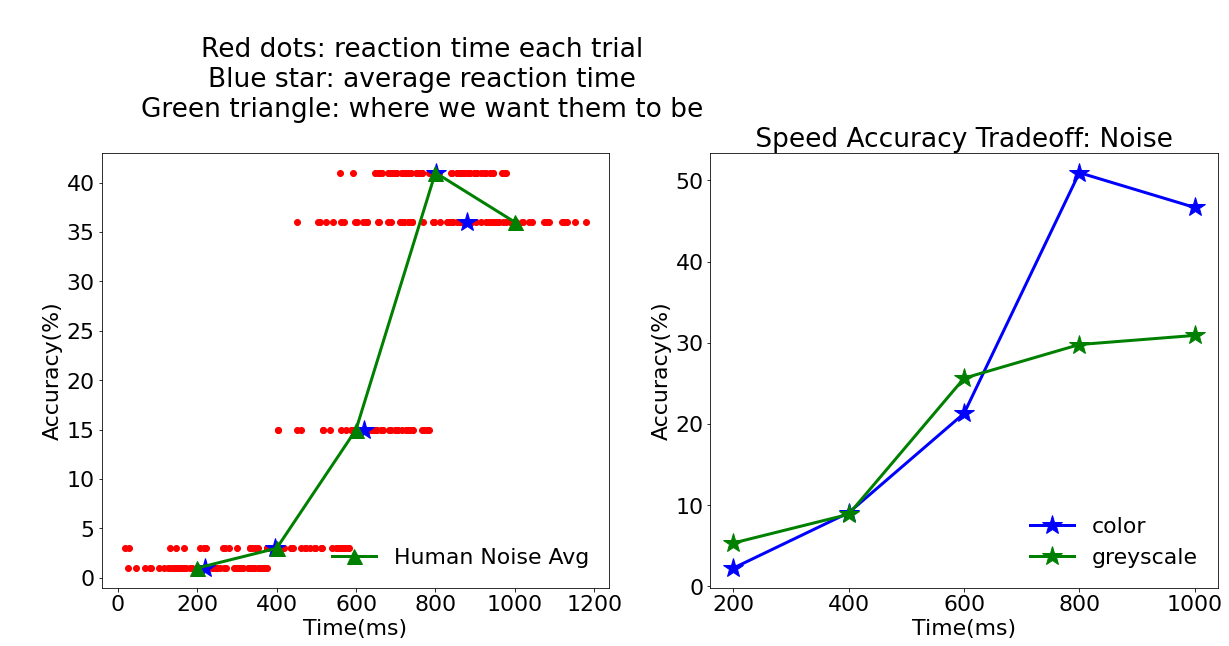

<Figure size 864x864 with 0 Axes>

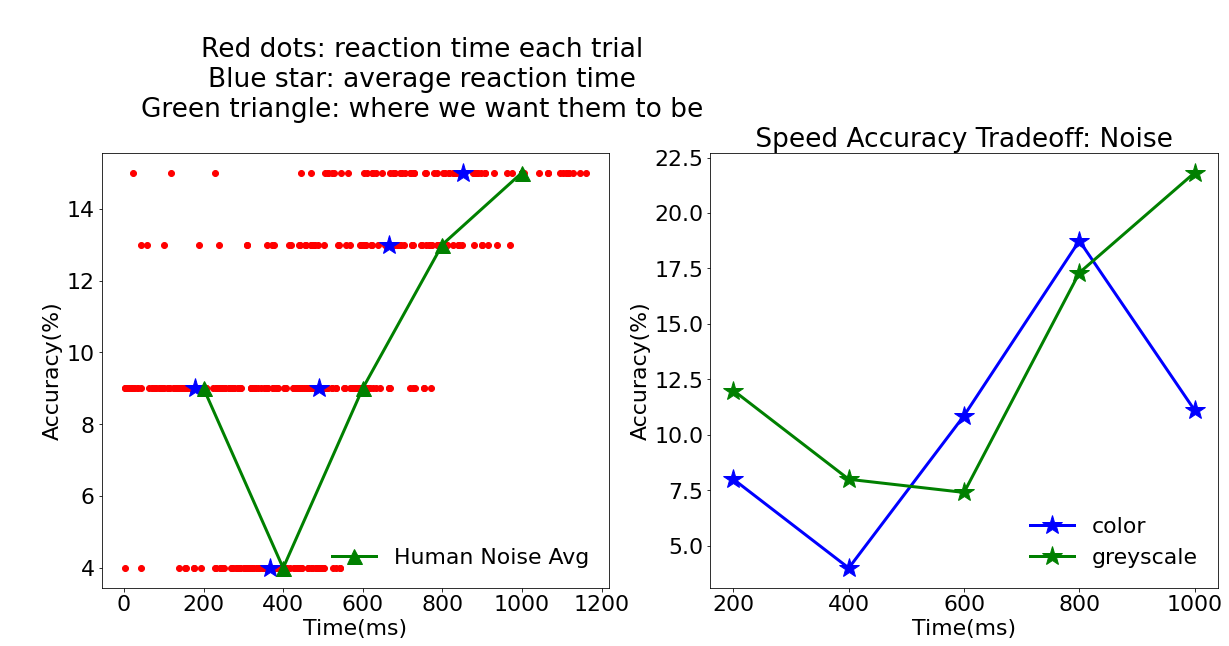

<Figure size 864x864 with 0 Axes>

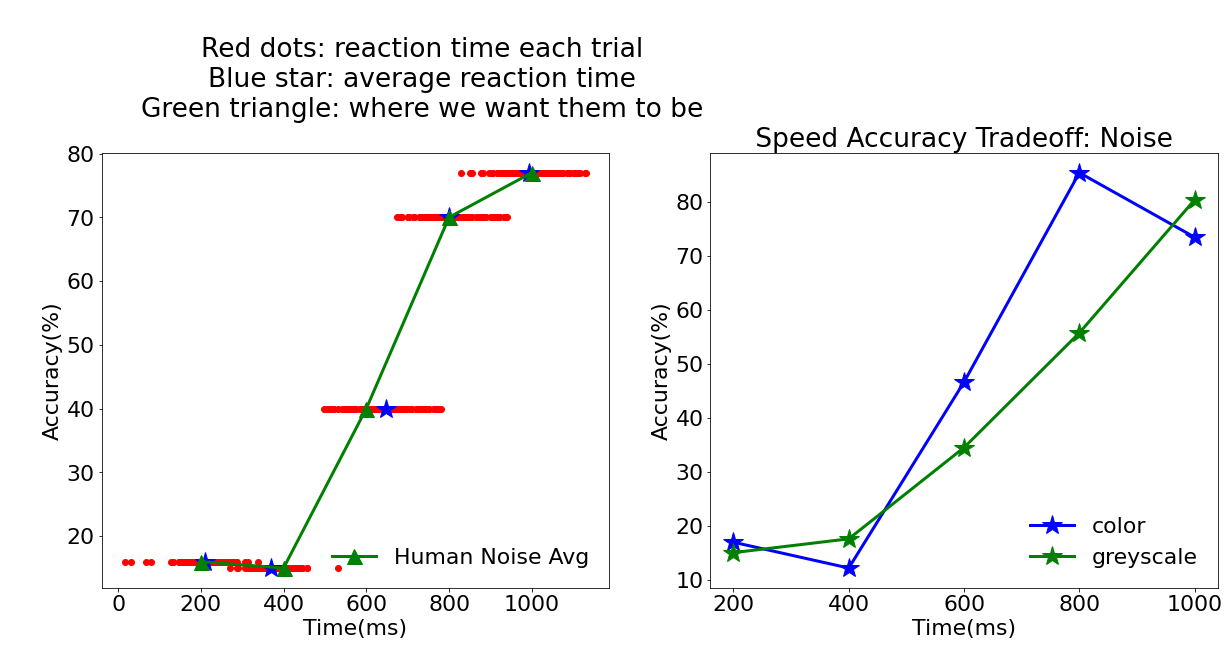

<Figure size 864x864 with 0 Axes>

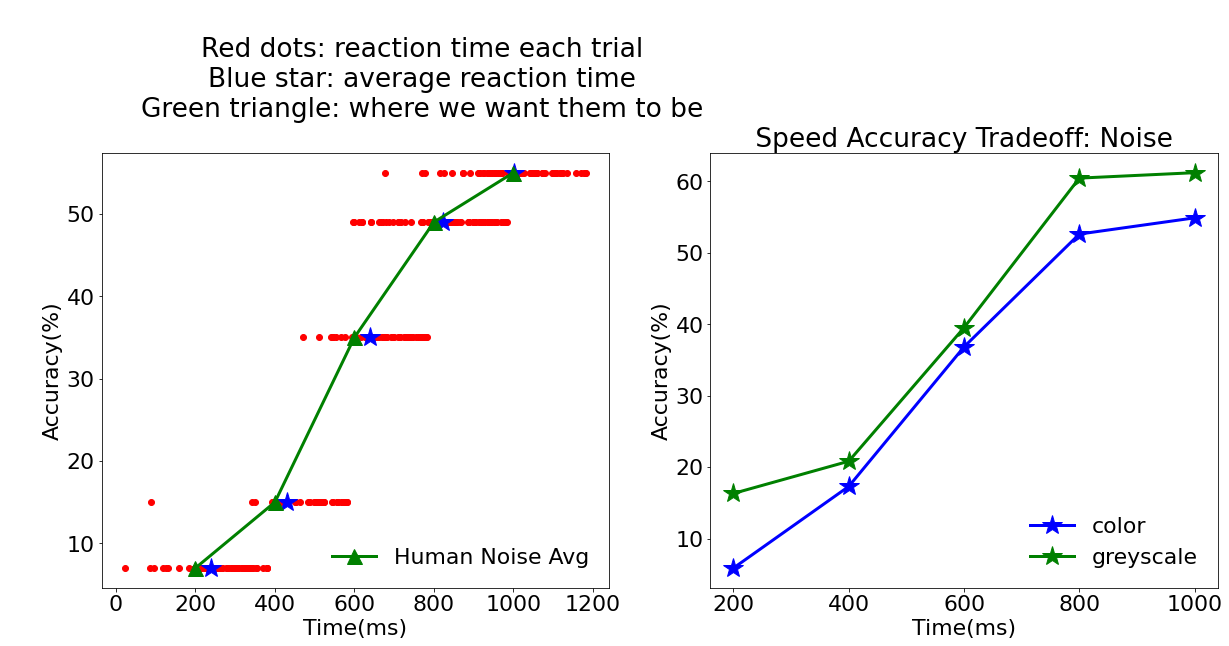

<Figure size 864x864 with 0 Axes>

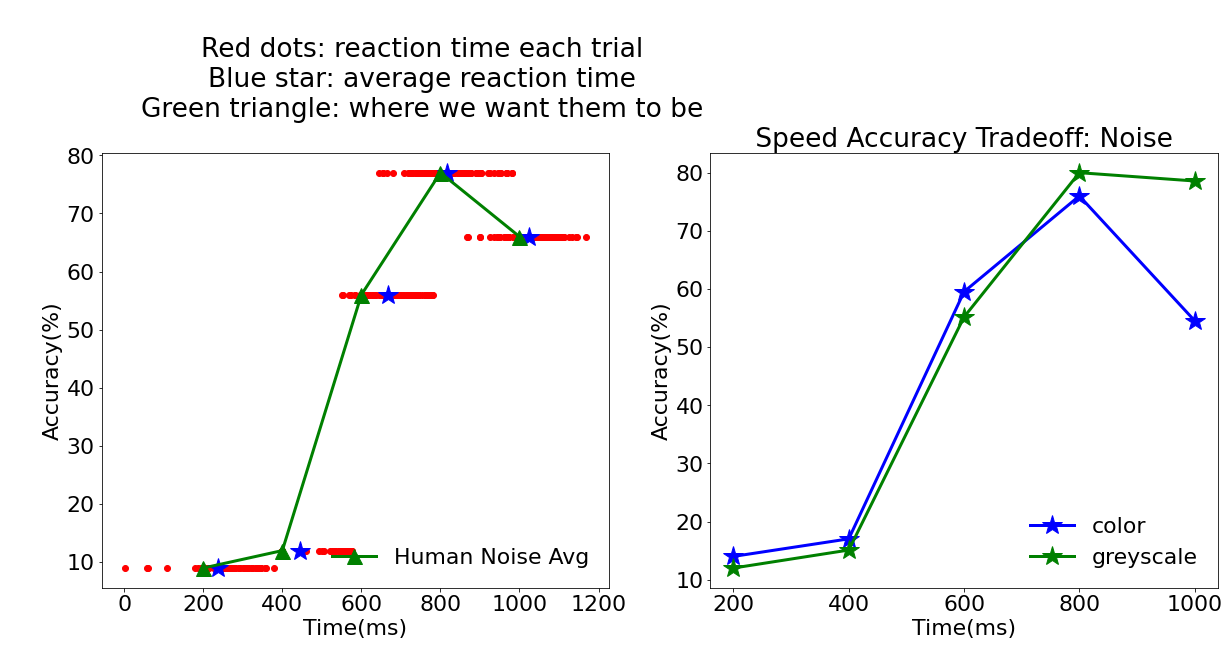

<Figure size 864x864 with 0 Axes>

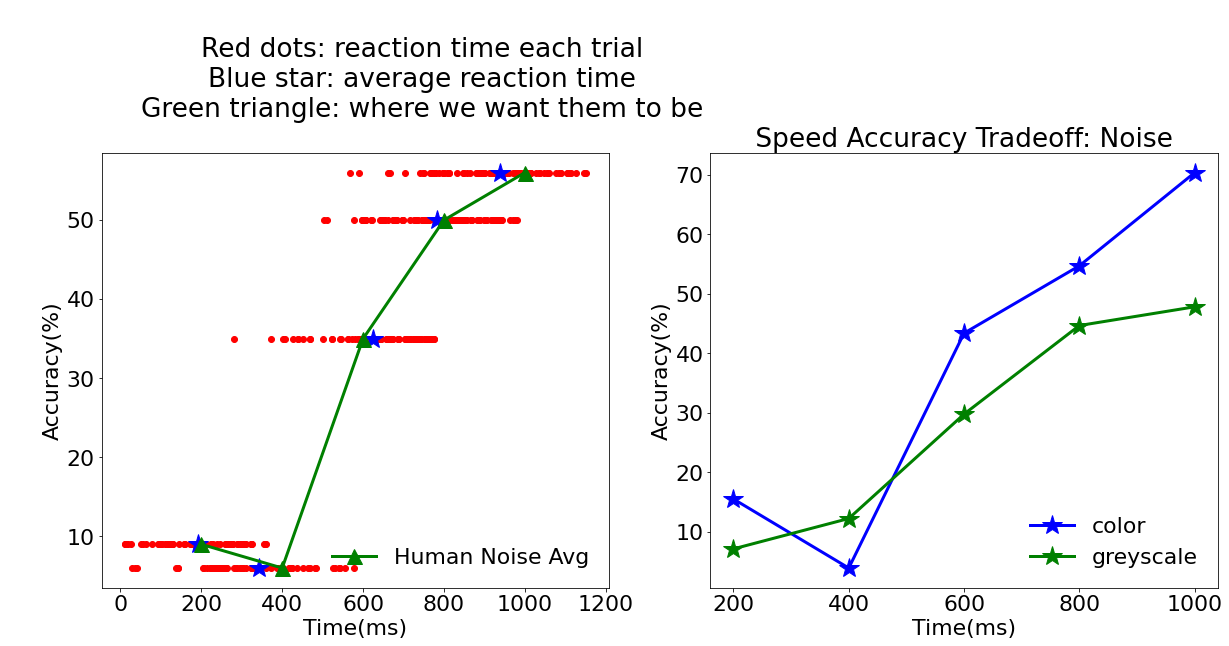

<Figure size 864x864 with 0 Axes>

In [23]:
import random
categories = ['dog', 'cat', 'truck', 'bird', 'airplane', 'deer', 'frog', 'ship', 'horse', 'automobile']
for file_path in files:
    with open(file_path,'rb') as f:
        df = pd.read_json(f)
    df = df[63:]
    types = {trial:[] for trial in list(set(list(df['sender']))) if trial.startswith('Trial_')}
    types_df = {trial:None for trial in list(set(list(df['sender']))) if trial.startswith('Trial_')}

    # iterate through the csv. They follow a pattern: Trial, followed by response, followed by stimulus
    # idx = Trial_200; Trial_1000 ech
    # idx + 1 = response
    # idx + 2 = inter-stimulus. You need correctResponse from it for getting noise information.

    for idx,values in df.iterrows():
        if values['sender'] in types.keys():
            imagename = df['correctResponse'][idx+2]
            if type(imagename) == str:
                noise = float(imagename.split('_')[0])
            else:
                noise = 0.0
            # for the case where no response was recorded
            if type(df['response'][idx+1]) == float:
                # if the observer could not press a key, assign a random category
                chance = random.choice(categories)
                types[values['sender']].append({'idx':len(types[values['sender']]),
                                            'duration':float(values['sender'].split('_')[-1]),
                                            'correct':df['correct'][idx+1],
                                            'correctResponse':df['category'][idx+1],
                                            'actualResponse':chance,
                                            'noise':noise})
                
                continue
            # when response was recorded. 
            types[values['sender']].append({'idx':len(types[values['sender']]),
                                            'duration':float(df['duration'][idx+1]),
                                            'correct':df['correct'][idx+1],
                                            'correctResponse':df['category'][idx+1],
                                            'actualResponse':df['response'][idx+1],
                                            'noise':noise
            })
    for key in types.keys():
        types_df[key] = pd.DataFrame.from_records(types[key])

    colors = {0:'b',1:'g',2:'r'}
    dataset = []

    for key in types.keys():
        types_df[key] = pd.DataFrame.from_records(types[key])
        tryme = types_df[key]
        for noise in [0,1]:
            count_correct = len(tryme[tryme['noise'] == noise][tryme['correctResponse']==tryme['actualResponse']])
            count_total = len(tryme[tryme['noise'] == noise])
            try:
                accuracy = count_correct / count_total
            except ZeroDivisionError:
                accuracy = 0
            dataset.append({'time':int(key.split('_')[-1]),'noise':float(noise),'acc':accuracy})
    sorted_data = pd.DataFrame.from_records(dataset).sort_values(by=['time'])

    #plotting data 
#     fig= plt.figure(figsize=(10,10))
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,8))
    
    ########### Plotting the avg of all noise
    times,acc,both,durs = [],[],[],[]
    avg_dur = []
    for i,key in enumerate(types.keys()):
        try:
            accuracy = calculate_percent_correct(types[key])
        except ZeroDivisionError:
            accuracy = 0
        time = int(key.split('_')[-1])
        times.append(time)
        acc.append(accuracy)
        both.append([time,i])
        durs.append(get_duration_unfiltered(key,types))
        avg_dur.append(np.average(get_duration_unfiltered(key,types)))
    both.sort(key=lambda x: x[0])
    acc = [acc[value[1]] for value in both]
    durs = [durs[value[1]] for value in both] 
    avg_dur = [avg_dur[value[1]] for value in both] 
    
    times = sorted(times)
    fig= plt.figure(figsize=(12,12))


    for i,dur in enumerate(durs):
        y = [acc[i]]*len(dur)
        x = dur
        ax1.plot(x,y,'ro')
        
    ax1.plot(avg_dur,acc,'b*',markersize='20')
    
        
    
    # human data
    ax1.plot(times,acc,'g^-',markersize='15',linewidth='3',label='Human Noise Avg')
    ax1.legend(loc='lower right',frameon=False)
    ax1.set_title("""
                Red dots: reaction time each trial
                Blue star: average reaction time
                Green triangle: where we want them to be
                """)
    ax1.set_xlabel('Time(ms)')
    ax1.set_ylabel('Accuracy(%)')
    
    # for each level of noise: 
    for i,noise in enumerate([0,1]):
        # noise = 0.0
        if noise == 0:
            lab = 'color'
        else:
            lab = 'greyscale'
        pltd = sorted_data[sorted_data['noise'] == noise]
        # human data for noise
        ax2.plot(pltd.time,[100*acc for acc in pltd.acc],'{}*-'.format(colors[i]),
                 linewidth='3',markersize='20',
                 label=lab)

        ax2.legend(loc='lower right',frameon=False)
        ax2.set_title(""" Speed Accuracy Tradeoff: Noise """)
        ax2.set_xlabel('Time(ms)')
        ax2.set_ylabel('Accuracy(%)')
    plt.show()
    processed = 'processed_color'
    if not os.path.exists(processed):
        os.makedirs(processed)
    
    sorted_data.to_csv(os.path.join(processed,file_path.split('/')[-1]))

In [22]:
types_df

{'Trial_400':     idx  duration  correct correctResponse actualResponse  noise
 0     0   400.000      NaN        airplane           deer    0.0
 1     1   400.000      NaN             dog            dog    0.0
 2     2   227.581      1.0             dog            dog    1.0
 3     3   424.172      0.0        airplane            dog    0.0
 4     4   400.000      NaN            frog          truck    0.0
 ..  ...       ...      ...             ...            ...    ...
 95   95   400.000      NaN      automobile           frog    1.0
 96   96   577.046      0.0           truck            cat    0.0
 97   97   303.245      0.0             dog          truck    0.0
 98   98   400.000      NaN      automobile          truck    1.0
 99   99   400.000      NaN             NaN          horse    0.0
 
 [100 rows x 6 columns],
 'Trial_800':     idx  duration  correct correctResponse actualResponse  noise
 0     0   841.875      1.0            bird           bird    0.0
 1     1   806.626     

## Plotting the ideal observer - Noise

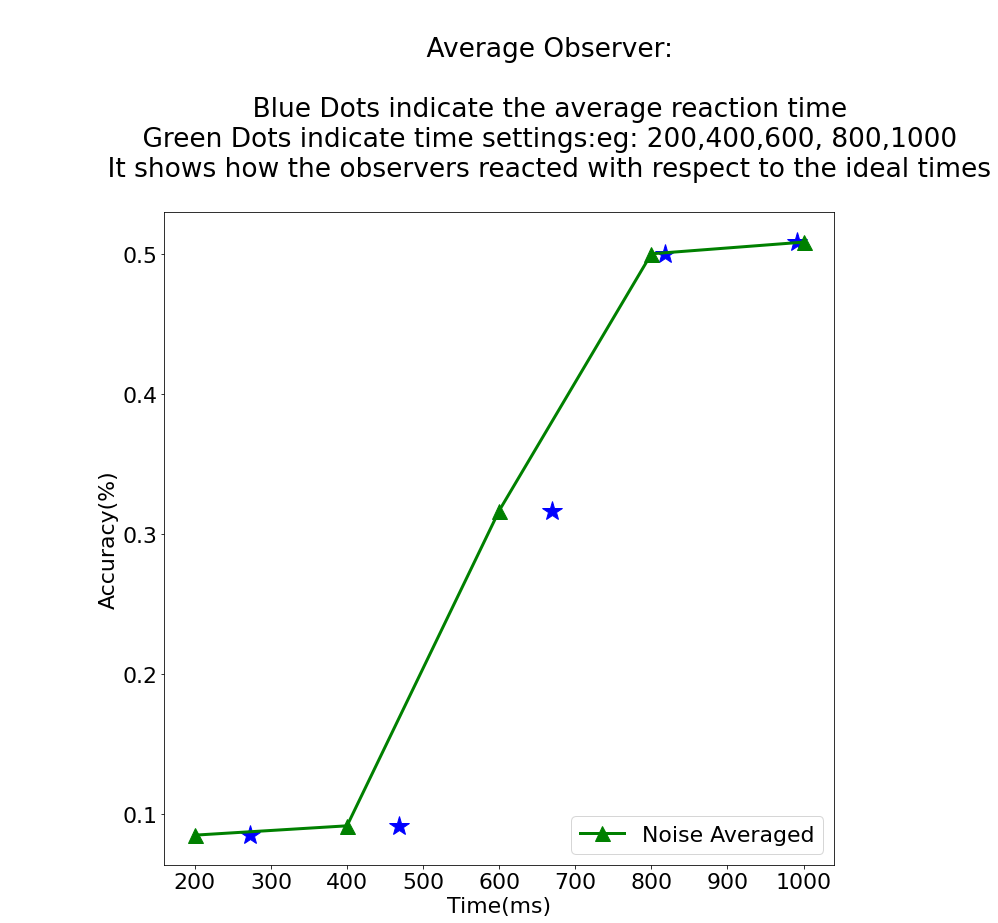

In [90]:
def calculate_percent_correct_count(type_):
    count = 0
    for val in type_:
        if val['correct'] == 1:
            count += 1
    return count,len(type_)

type_labels = ['Trial_200','Trial_400','Trial_600','Trial_800','Trial_1000']
types = {trial:[] for trial in type_labels}

coun = {key:0 for key in types.keys()}
tot = {key:0 for key in types.keys()}
durr = {key:[] for key in range(200,2001,200)}

for file_path in files:    
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith('.txt'):
        with open(file_path,'rb') as f:
            df = pd.read_json(f)
    else:
        print('No file found')
    
    df = df[63:]
    types = {trial:[] for trial in list(set(list(df['sender']))) if trial.startswith('Trial_')}
    for idx,values in df.iterrows():
        if values['sender'] in types.keys():
            if not df['response'][idx+1]:
                continue
            types[values['sender']].append({'idx':len(types[values['sender']]),
                                            'duration':df['duration'][idx+1],
                                            'correct':df['correct'][idx+1],
                                            'correctResponse':df['category'][idx+1],
                                            'actualResponse':df['response'][idx+1]

            })

    times,acc,both,durs = [],[],[],[]
    for i,key in enumerate(types.keys()):
        counts,totals = calculate_percent_correct_count(types[key])
        # to get average
        coun[key] += counts
        tot[key] += totals
        
        time = int(key.split('_')[-1])
        times.append(time)
#         acc.append(accuracy)
        both.append([time,i])
        durs.append(get_duration_unfiltered(key,types))
        durr[time].extend(get_duration_unfiltered(key,types))
        
    both.sort(key=lambda x: x[0])
#     acc = [acc[value[1]] for value in both]
    durs = [durs[value[1]] for value in both] 
    times = sorted(times)

# for i,dur in enumerate(durs):
#     y = [acc[i]]*len(dur)
#     x = dur
#     plt.plot(x,y,'ro')
fig= plt.figure(figsize=(12,12))

plotty = {}
for key,value in coun.items():
    try:
        plotty[int(key.split('_')[1])] = value/tot[key]
    except ZeroDivisionError:
        plotty[int(key.split('_')[1])] = 0

# for average observer
acccs,timess,durrr = [],[],[]
for i in range(200,1001,200):
    acccs.append(plotty[i])
    timess.append(i)
    durrr.append(np.average(durr[i]))

plt.plot(durrr,acccs,'b*',markersize='20')
plt.plot(timess,acccs,'g^-',markersize='15',linewidth='3',label='Noise Averaged')

plt.legend(loc='lower right')
plt.title("""
            Average Observer:
            
            Blue Dots indicate the average reaction time
            Green Dots indicate time settings:eg: 200,400,600, 800,1000
            It shows how the observers reacted with respect to the ideal times
            """)
plt.xlabel('Time(ms)')
plt.ylabel('Accuracy(%)')
plt.show()

## Plotting Reaction Times and Finding Correlation with the ideal observer

In [91]:
from scipy.stats import pearsonr

In [92]:
def exclude_observer(col,matrix):
    b = np.array([matrix[:][i] for i in range(matrix.shape[0]) if i != col])
    return b

In [93]:
def plot_reaction_times(file_path):
    
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith('.txt'):
        with open(file_path,'rb') as f:
            df = pd.read_json(f)
    else:
        print('No file found')
    
    # this is done for skipping the tutorial section
    df = df[63:]
    types = {trial:[] for trial in list(set(list(df['sender']))) if trial.startswith('Trial_')}
    for idx,values in df.iterrows():
        if values['sender'] in types.keys():
            if not df['response'][idx+1]:
                continue
#             print(df['category'][idx+1],df['response'][idx+1])
            # you can now access the next index which has response 
            types[values['sender']].append({'idx':len(types[values['sender']]),
                                            'duration':df['duration'][idx+1],
                                            'correct':df['correct'][idx+1],
                                            'correctResponse':df['category'][idx+1],
                                            'actualResponse':df['response'][idx+1]
            })

    times,acc,both,durs = [],[],[],[]
    avg_dur = []
    for i,key in enumerate(types.keys()):
        accuracy = calculate_percent_correct(types[key])
        time = int(key.split('_')[-1])
        times.append(time)
        acc.append(accuracy)
        both.append([time,i])
        durs.append(get_duration_unfiltered(key,types))
        avg_dur.append(np.average(get_duration_unfiltered(key,types)))
    both.sort(key=lambda x: x[0])
    acc = [acc[value[1]] for value in both]
    durs = [durs[value[1]] for value in both] 
    avg_dur = [avg_dur[value[1]] for value in both] 
    
    times = sorted(times)
    fig= plt.figure(figsize=(12,12))


    for i,dur in enumerate(durs):
        y = [acc[i]]*len(dur)
        x = dur
        plt.plot(x,y,'ro')
        
    plt.plot(avg_dur,acc,'b*',markersize='20')
    
        
    
    # human data
    plt.plot(times,acc,'g^-',markersize='15',linewidth='3',label='Human#1 Noise Averaged')

    plt.legend(loc='lower right')
    plt.title("""
                Red dots indicate reaction time for each trial
                Blue Dots indicate the average reaction time
                """)
    plt.xlabel('Time(ms)')
    plt.ylabel('Accuracy(%)')
    plt.show()
    
    return acc,avg_dur

file:./color_gray/jatos_results_20210523222838.txt


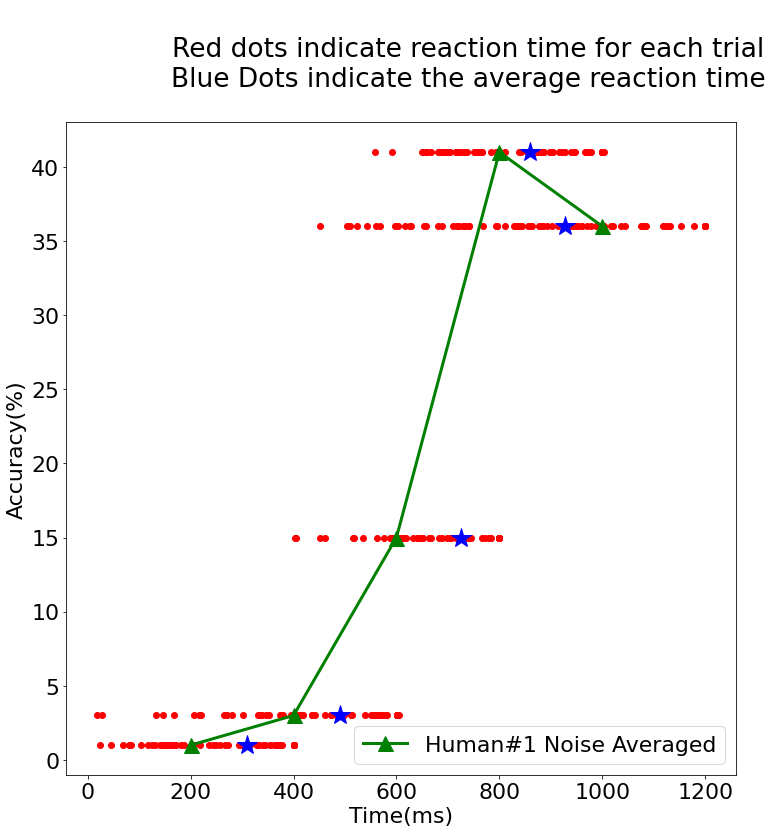

file:./color_gray/jatos_results_20210523222817.txt


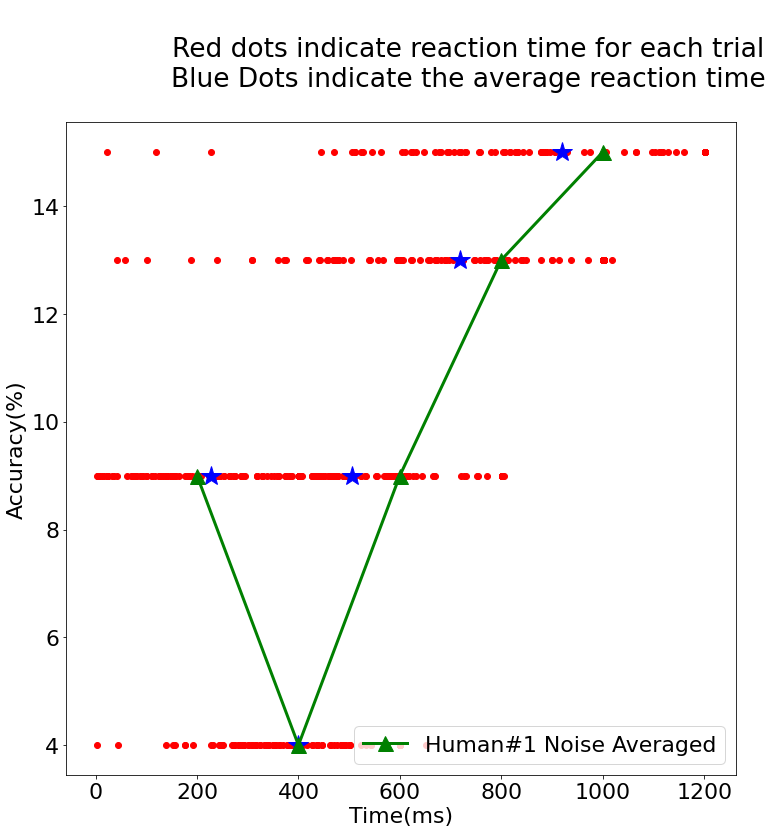

file:./color_gray/jatos_results_20210523222843.txt


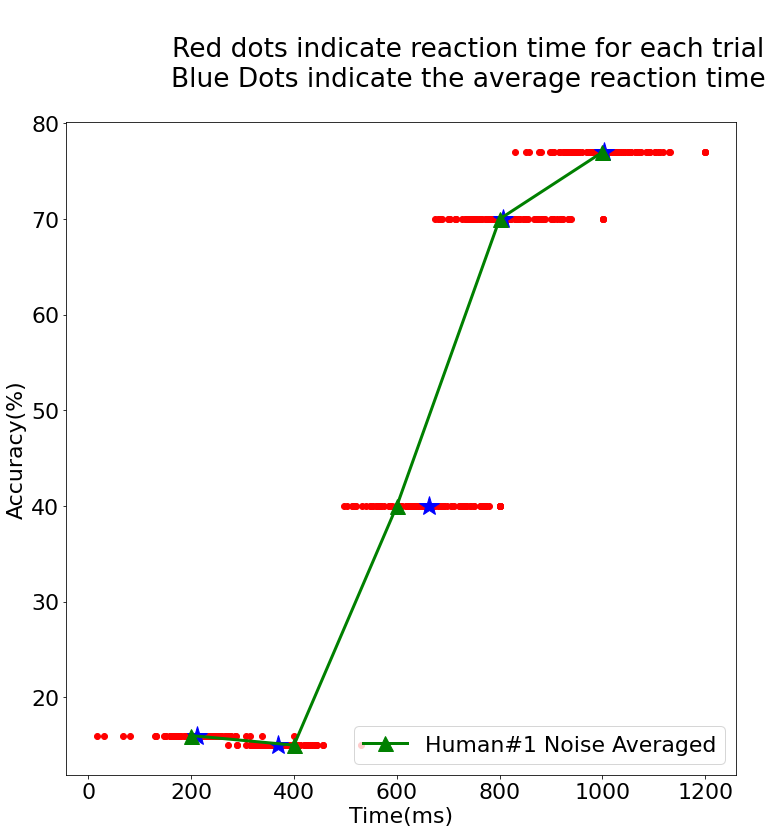

file:./color_gray/jatos_results_20210523222827.txt


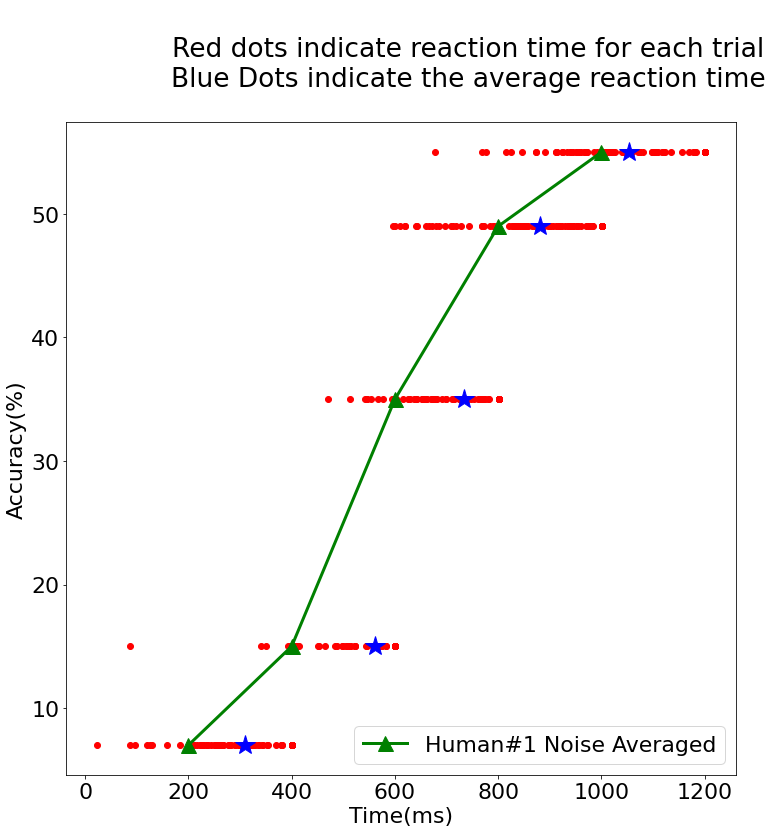

file:./color_gray/jatos_results_20210523222832.txt


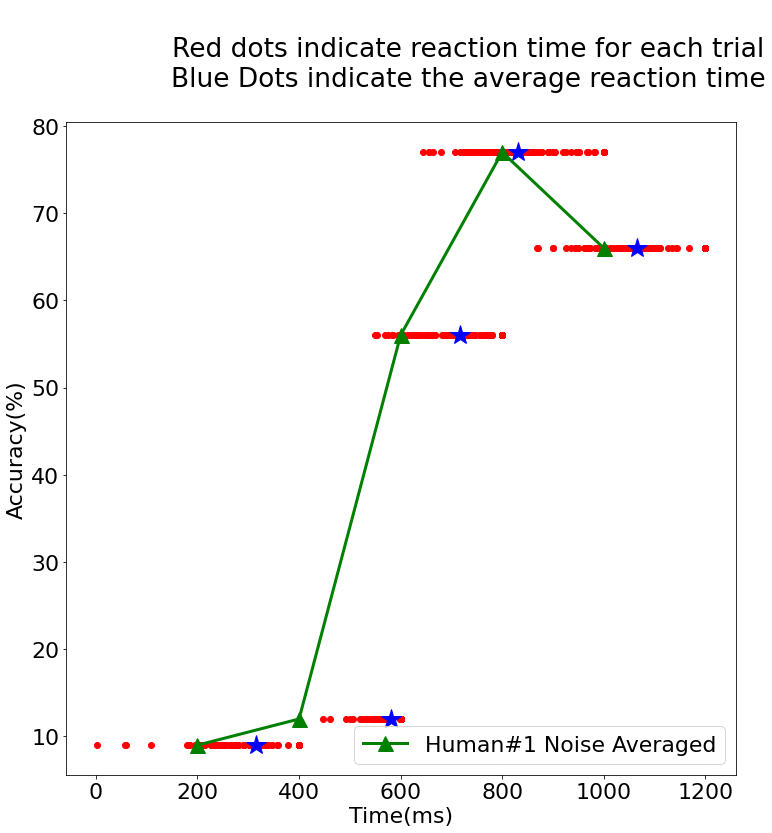

file:./color_gray/jatos_results_20210523222823.txt


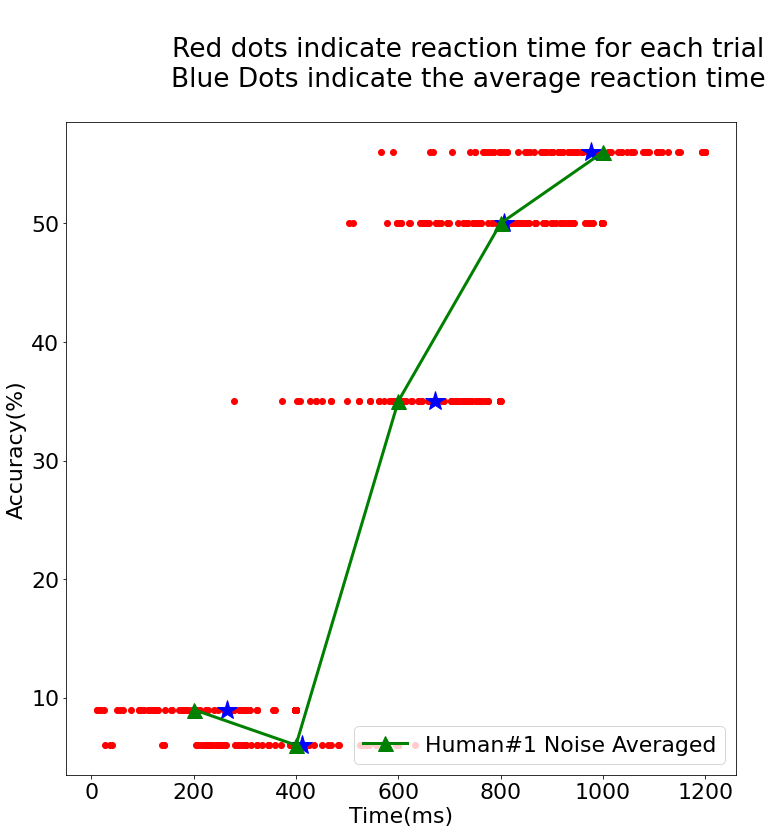

In [94]:
ac,rt = [],[]
for file in files:
    print('file:{}'.format(file))
    a,r = plot_reaction_times(file)
    ac.append(a)
    rt.append(r)

In [95]:
reaction_times = np.array(rt)
accuracies = np.array(ac)

In [96]:
correlations = {}
accuracies_paper = {0.0: [10,69.9, 75.93, 79.88, 82.25, 84.39, 84.77, 85.18],
                     0.4: [10,62.76, 70.01, 75.73, 78.83, 80.97, 81.24, 81.74],
                     0.75: [10,39.48, 38.83, 52.61, 53.78, 59.58, 61.95, 60.71],
                     1.5: [10,13.72, 11.88, 15.54, 16.67, 15.73, 17.31, 13.2]}

for noise,mod in accuracies_paper.items():
    print('correlation between model with noise:{}'.format(noise))
    mod_acc = np.array(list(mod))
    rel = []
    for ob in range(len(accuracies)):
        print('Observer Number:',ob+1)
#         avg_minus_current = np.average(exclude_observer(ob,accuracies),axis=0)
        corr, _ = pearsonr(mod_acc[:5], accuracies[ob])
        rel.append(corr)
        print('Pearsons correlation for percent correct: %.3f' % corr)
        print('*'*10)
    print('*'*20)
    correlations['model_{}'.format(noise)] = rel



# correlation between current human vs avg of rest
rel = []
for ob in range(len(accuracies)):
    print('Observer Number:',ob+1)
    avg_minus_current = np.average(exclude_observer(ob,accuracies),axis=0)
    corr, _ = pearsonr(avg_minus_current, accuracies[ob])
    rel.append(corr)
    print('Pearsons correlation for percent correct: %.3f' % corr)
    print('*'*10)

correlations['obs'] = rel


correlation between model with noise:0.0
Observer Number: 1
Pearsons correlation for percent correct: 0.664
**********
Observer Number: 2
Pearsons correlation for percent correct: 0.283
**********
Observer Number: 3
Pearsons correlation for percent correct: 0.652
**********
Observer Number: 4
Pearsons correlation for percent correct: 0.781
**********
Observer Number: 5
Pearsons correlation for percent correct: 0.725
**********
Observer Number: 6
Pearsons correlation for percent correct: 0.663
**********
********************
correlation between model with noise:0.4
Observer Number: 1
Pearsons correlation for percent correct: 0.707
**********
Observer Number: 2
Pearsons correlation for percent correct: 0.343
**********
Observer Number: 3
Pearsons correlation for percent correct: 0.699
**********
Observer Number: 4
Pearsons correlation for percent correct: 0.818
**********
Observer Number: 5
Pearsons correlation for percent correct: 0.761
**********
Observer Number: 6
Pearsons correlation

For human efficiency:
             circles denote correlation of an observer with all others.
             Big triangle denotes the mean correlation
         For models:
             circles denote correlation between percent correct of each observer with model
             Big triangle denotes the mean correlation
        


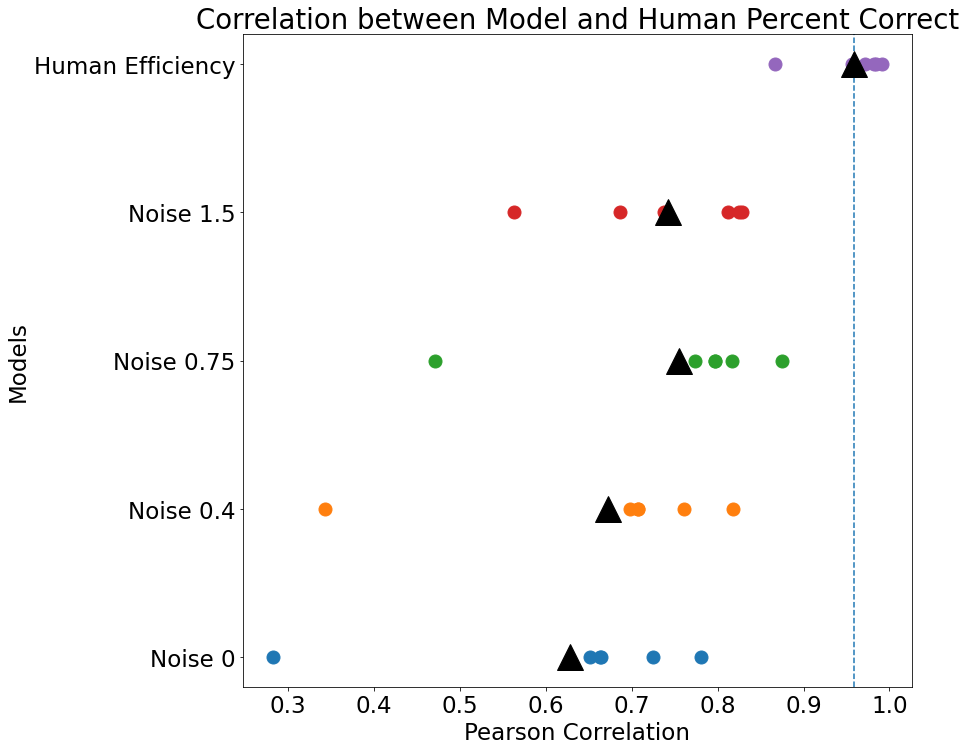

In [97]:
print("""For human efficiency:
             circles denote correlation of an observer with all others.
             Big triangle denotes the mean correlation
         For models:
             circles denote correlation between percent correct of each observer with model
             Big triangle denotes the mean correlation
        """)
import matplotlib.pyplot as plt
%matplotlib inline
SMALL_SIZE=23
plt.rc('font', size=SMALL_SIZE)
fig, ax = plt.subplots(figsize=(12, 12))
labs = []
for i,(key,value) in enumerate(correlations.items()):
    if key == 'obs':
        plt.axvline(x=np.average(np.array(value)),linestyle='--')
        color = 'black'
        labs.append('Observer')
    else:
        color = 'black'
        labs.append('Noise {}'.format(key))
    x = value
    y = [i+1]*len(x)
    plt.plot(x,y,'o',markersize=13,linewidth=3.0)
    plt.plot([np.average(np.array(x))],[i+1],'^',color = color,markersize=26,linewidth=3.0)

plt.yticks(np.arange(1,6,step=1),['Noise 0','Noise 0.4','Noise 0.75','Noise 1.5','Human Efficiency'])
plt.xlabel('Pearson Correlation')
plt.ylabel('Models')
plt.title('Correlation between Model and Human Percent Correct')
plt.show()

In [24]:
os.listdir('processed_color')

['jatos_results_20210523222838.txt',
 'jatos_results_20210523222817.txt',
 'jatos_results_20210523222843.txt',
 'jatos_results_20210523222827.txt',
 'jatos_results_20210523222832.txt',
 'jatos_results_20210523222823.txt']